In [ ]:
!pip3 install pandas

In [ ]:
# Read In Data
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


goalies_df = pd.read_csv('/content/drive/My Drive/Goalies.csv', on_bad_lines="skip")
teams_df = pd.read_csv('/content/drive/My Drive/Teams.csv')

Mounted at /content/drive


In [46]:
# Merge datasets
merged_df = pd.merge(
    teams_df,
    goalies_df,
    on=['year', 'tmID'],
    how='inner'
)

# 1. Drop unnecessary columns
columns_to_drop = ['lgID_y', 'confID', 'divID', 'franchID', 'name',
                  'PostGP', 'PostMin', 'PostW', 'PostL', 'PostT', 'PostENG',
                  'PostSHO', 'PostGA', 'PostSA', 'playoff', 'rank', 'ENG',
                  'lgID_x', 'GA_y', 'W_x', 'L_x', 'T', 'OTL', 'W_y', 'L_y',
                  'T/OL', 'SoW', 'SoL']
cleaned_df = merged_df.drop(columns=columns_to_drop)

# 2. Rename columns for clarity
cleaned_df = cleaned_df.rename(columns={'GA_x': 'GA'})

# 3. Group by team and year to get team-level statistics
team_stats = cleaned_df.groupby(['year', 'tmID']).agg({
    'G': 'first',          # Games played by team
    'Pts': 'first',        # Team points
    'GF': 'first',         # Goals for
    'GA': 'first',         # Goals against
    'GP': 'sum',           # Total games played by goalies
    'Min': 'sum',          # Total minutes by goalies
    'SHO': 'sum',          # Total shutouts
    'SA': 'sum',           # Total shots against
    'PIM': 'first',        # Penalties in minutes
    'PPG': 'first',        # Power play goals
    'PPC': 'first',        # Power play chances
    'PKG': 'first',        # Penalty kill goals against
    'PKC': 'first'         # Penalty kill chances
}).reset_index()

# 4. Calculate additional metrics
team_stats['SavePercentage'] = (team_stats['SA'] - team_stats['GA']) / team_stats['SA']
team_stats['GoalsAgainstAvg'] = (team_stats['GA'] * 60) / team_stats['Min']

# 5. Handle missing/infinite values
team_stats = team_stats.replace([np.inf, -np.inf], np.nan)

# Prepare features and target
features_to_drop = ['Pts', 'year', 'tmID']
X = team_stats.drop(columns=features_to_drop)
y = team_stats['Pts']

# 1. Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~X.isna().any(axis=1)  # Create mask of rows without NaN
X = X[mask]
y = y[mask]


,G,GF,GA,GP,Min,SHO,SA,PIM,PPG,PPC,PKG,PKC,SavePercentage,GoalsAgainstAvg
501,78,269,256,84.0,4739.0,2.0,2487.0,843.0,48.0,248.0,56.0,252.0,0.897065,3.241190
505,78,245,295,88.0,4750.0,1.0,2747.0,811.0,45.0,248.0,57.0,253.0,0.892610,3.726316
507,78,287,239,78.0,4753.0,5.0,2581.0,1095.0,51.0,272.0,59.0,338.0,0.907400,3.017042
510,78,284,269,80.0,4743.0,1.0,2510.0,1363.0,50.0,188.0,63.0,330.0,0.892829,3.402910
512,78,259,250,88.0,4755.0,3.0,2106.0,1477.0,51.0,259.0,59.0,315.0,0.881292,3.154574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,82,240,234,89.0,4948.0,10.0,2268.0,1225.0,52.0,279.0,51.0,279.0,0.896825,2.837510
1485,82,247,240,89.0,4994.0,7.0,2347.0,905.0,69.0,336.0,49.0,302.0,0.897742,2.883460
1486,82,218,251,93.0,4955.0,3.0,2531.0,985.0,52.0,326.0,62.0,275.0,0.900830,3.039354
1487,82,262,185,85.0,4962.0,5.0,2467.0,943.0,72.0,296.0,45.0,312.0,0.925010,2.237001


# Rianna Gillies - Code portion

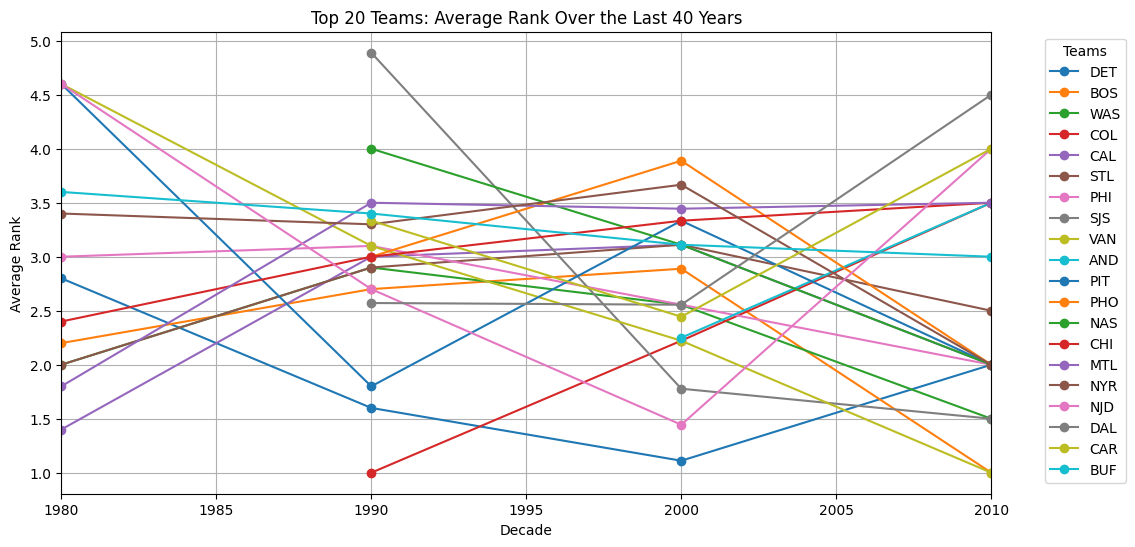

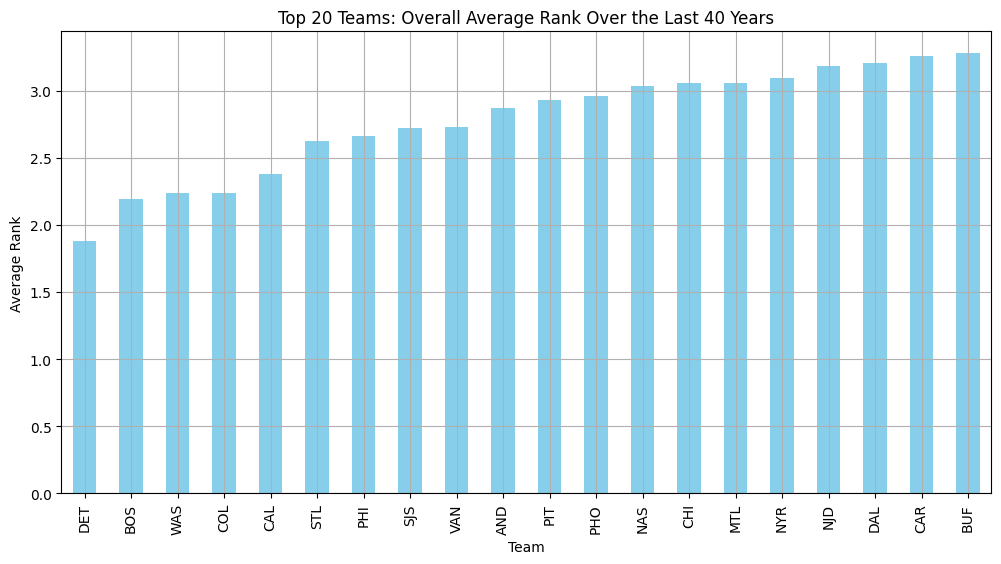

Number of Rows: 72
Number of Columns: 3
Query execution time: 0.616 seconds

   Decade tmID  rank
0    1980  BOS   2.2
1    1980  BUF   3.6


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

start_time = time.time()

# Using our data teams
df = teams_df.copy()

# Get the current year
current_year = pd.to_datetime('today').year

# Only include data from the last 40 years
df_last_40_years = df[df['year'] >= (current_year - 40)]

# Create a decade variable
df_last_40_years.loc[:, 'Decade'] = (df_last_40_years['year'] // 10) * 10

# Group by Decade and team, and calculate the mean rank for each group
new_df = df_last_40_years.groupby(['Decade', 'tmID'])['rank'].mean().reset_index()

# Get the top 20 teams based on their overall average rank
top_20_teams = new_df.groupby('tmID')['rank'].mean().sort_values().head(20).index

# Filter the data for the top 20 teams
top_20_teams_data = new_df[new_df['tmID'].isin(top_20_teams)]

# Plotting
plt.figure(figsize=(12, 6))

# Loop through the top 20 teams and plot their average rank over the decades
for team in top_20_teams:
    team_data = top_20_teams_data[top_20_teams_data['tmID'] == team]

    # Plot the team's average rank across decades
    plt.plot(team_data['Decade'], team_data['rank'], label=team, marker='o')

# Ensure the x-axis spans all decades
plt.xlim(new_df['Decade'].min(), new_df['Decade'].max())

# Customize the plot
plt.title(f'Top 20 Teams: Average Rank Over the Last 40 Years')
plt.xlabel('Decade')
plt.ylabel('Average Rank')
plt.legend(title="Teams", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Second graph: Bar plot showing overall average rank for each team in the last 40 years
plt.figure(figsize=(12, 6))

# Get the average rank of top 20 teams over the last 40 years
team_avg_rank = new_df[new_df['tmID'].isin(top_20_teams)].groupby('tmID')['rank'].mean().sort_values()

# Plot a bar chart of the average rank for each of the top 20 teams
team_avg_rank.plot(kind='bar', color='skyblue')

# Customize the plot
plt.title(f'Top 20 Teams: Overall Average Rank Over the Last 40 Years')
plt.xlabel('Team')
plt.ylabel('Average Rank')
plt.xticks(rotation=90)
plt.grid(True)

# Show the plot
plt.show()

# Count Rows
print(f"Number of Rows: {len(top_20_teams_data)}")
print(f"Number of Columns: {top_20_teams_data.shape[1]}")

end_time = time.time()
print(f"Query execution time: {end_time - start_time:.3f} seconds")
print("")
print(top_20_teams_data.head(2))